<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_8968/1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


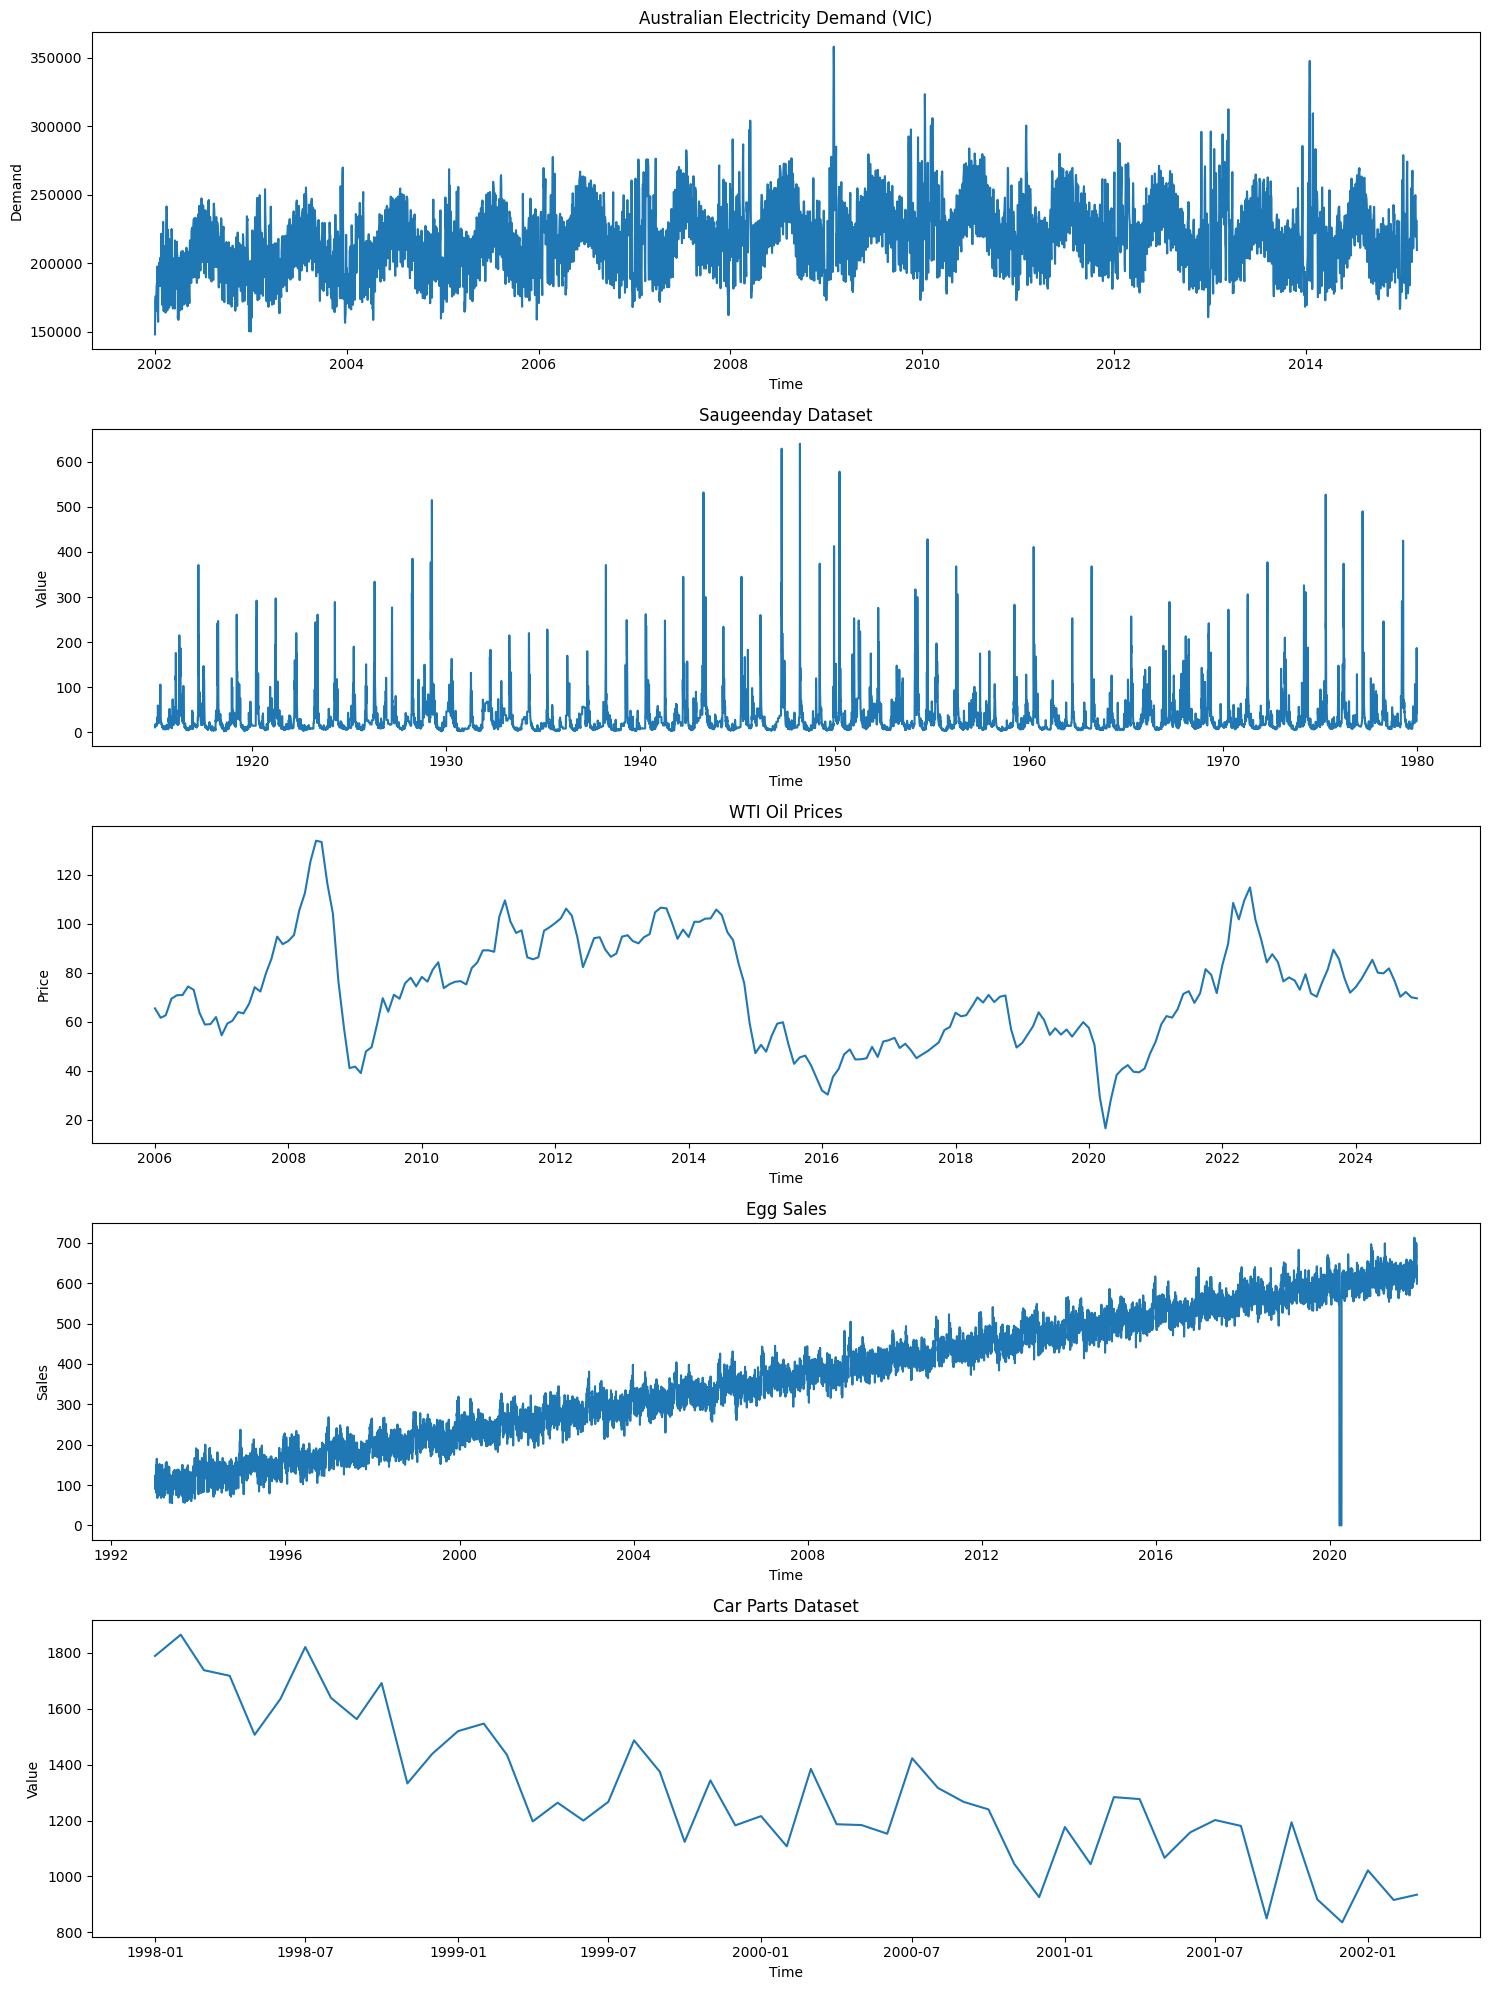

In [1]:
%run 'datagetter.ipynb'
%run 'basic_functions.ipynb'


In [ ]:
# sarima_model.py
"""
Utility to automate SARIMA modeling for a univariate time-series DataFrame.

Revision 1.3 (06 Jul 2025)
––––––––––––––––––––––––––
* **STL-driven seasonality discovery**: if you don’t provide ``seasonal_period``
  the routine now loops over a set of plausible periods (daily/weekly/annual
  relative to the sampling rate), decomposes each with STL, and chooses the
  one with the strongest seasonal variance.  Falls back to the old calendar
  rule or ACF-peak if STL finds nothing.

Usage
-----
>>> sarima_forecast(df)              # autodetect via STL → SARIMA/ARIMA
>>> sarima_forecast(df, 48)          # force daily seasonality for 30-min data
>>> sarima_forecast(df, 0)           # force non-seasonal ARIMA
"""

import itertools
import re
from sklearn.model_selection import train_test_split
import warnings
from typing import Tuple, Optional, Dict, Any, List
from pandas.tseries.frequencies import to_offset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import periodogram, welch, find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------
def auto_detect_strongest_cycle(ts: pd.Series,
                                max_period: int = 100
                               ) -> tuple[str, int, float]:
    """
    Infer sampling freq of `ts` (must have uniform DatetimeIndex),
    build candidate seasonal periods appropriate to that resolution
    (and ≤ max_period), then pick the one with highest autocorrelation.

    Returns
    -------
    best_name : str      e.g. "daily", "quarterly", "annual"
    best_period : int    number of samples in one cycle
    best_corr : float    autocorrelation at that lag
    """
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise ValueError("`ts` must have a DatetimeIndex")
    ts = ts.sort_index().dropna()

    # 1) infer frequency
    freq = pd.infer_freq(ts.index)
    off = to_offset(freq)
    # check if time-based or month/year-based
    has_seconds = hasattr(off, 'delta')
    candidates = {}

    if has_seconds and off.delta.total_seconds() < 86400:
        # sub-daily (e.g. 30T, H, etc.)
        sec = off.delta.total_seconds()
        per_day = int(86400 // sec)
        candidates = {
            "daily":   per_day,
            "weekly":  per_day * 7,
            "monthly": per_day * 30,
            "yearly":  per_day * 365,
        }
    else:
        # day or coarser
        s = off.freqstr.upper()
        if s in ("D","B"):
            candidates = {
                "weekly": 7,
                "monthly": 30,
                "annual": 365,
            }
        elif s in ("M", "MS", "BM"):
            candidates = {
                "quarterly": 3,
                "semiannual": 6,
                "annual": 12,
            }
        elif s in ("Q","BQ"):
            candidates = {
                "semiannual": 2,
                "annual": 4,
            }
        elif s in ("A","Y","BA"):
            candidates = {
                "annual": 1,
            }
        else:
            # fallback: no good candidates
            raise ValueError(f"Unrecognized frequency '{freq}' for auto-detection.")

    # 2) filter by max_period
    candidates = {n: p for n, p in candidates.items() if p <= max_period}
    if not candidates:
        raise ValueError(f"No candidate periods ≤ {max_period}. Increase `max_period`.")

    # 3) compute autocorrelations
    corrs = {}
    for name, lag in candidates.items():
        # pandas autocorr uses `lag` in number of samples
        corrs[name] = ts.autocorr(lag=lag) or 0.0

    # 4) pick strongest (abs value)
    best_name, best_corr = max(corrs.items(), key=lambda kv: abs(kv[1]))
    best_period = candidates[best_name]

    return best_name, best_period, best_corr


def auto_detect_strongest_cycle_advanced(ts: pd.Series, 
                                        method='fourier', 
                                        min_period=2, 
                                        max_period=None,
                                        confidence_threshold=0.1,
                                        show_plots=True,
                                        figsize=(20, 12)):
    
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise ValueError("Time series must have a datetime index")
    
    ts = ts.dropna().astype(float)
    
    if len(ts) < min_period * 3:
        raise ValueError(f"Time series too short for cycle detection (length: {len(ts)})")
    
    if max_period is None:
        max_period = min(len(ts) // 3, 365)
    
    detrended = signal.detrend(ts.values)
    
    results = {
        'method': method,
        'series_length': len(ts),
        'cycles_detected': [],
        'strongest_cycle': None,
        'analysis_summary': {}
    }
    
    n = len(detrended)
    fft_values = fft(detrended)
    fft_freq = fftfreq(n)
    
    power_spectrum = np.abs(fft_values) ** 2
    
    positive_freq_mask = fft_freq > 0
    frequencies = fft_freq[positive_freq_mask]
    powers = power_spectrum[positive_freq_mask]
    periods = 1 / frequencies
    
    period_mask = (periods >= min_period) & (periods <= max_period)
    valid_periods = periods[period_mask]
    valid_powers = powers[period_mask]
    
    freq_periodogram, power_periodogram = periodogram(detrended)
    periods_periodogram = 1 / freq_periodogram[1:]
    power_periodogram = power_periodogram[1:]
    
    freq_welch, power_welch = welch(detrended, nperseg=min(len(detrended)//4, 256))
    periods_welch = 1 / freq_welch[1:]
    power_welch = power_welch[1:]
    
    peaks, peak_properties = find_peaks(valid_powers, 
                                       height=np.max(valid_powers) * confidence_threshold,
                                       distance=max(1, len(valid_powers) // 50))
    
    detected_cycles = []
    
    for peak_idx in peaks:
        period = valid_periods[peak_idx]
        power = valid_powers[peak_idx]
        relative_power = power / np.max(valid_powers)
        
        lag = int(round(period))
        if lag < len(ts) - 1:
            autocorr = np.corrcoef(ts.values[:-lag], ts.values[lag:])[0, 1]
        else:
            autocorr = 0
        
        detected_cycles.append({
            'period': period,
            'power': power,
            'relative_power': relative_power,
            'autocorrelation': autocorr,
            'frequency': 1/period,
            'significance_score': relative_power * abs(autocorr)
        })
    
    detected_cycles.sort(key=lambda x: x['significance_score'], reverse=True)
    
    try:
        if len(ts) >= 24:
            decomposition = seasonal_decompose(ts, model='additive', 
                                             period=max(7, int(detected_cycles[0]['period']) if detected_cycles else 12))
            seasonal_strength = np.var(decomposition.seasonal) / np.var(ts)
        else:
            seasonal_strength = 0
    except:
        seasonal_strength = 0
    
    results['cycles_detected'] = detected_cycles
    results['strongest_cycle'] = detected_cycles[0] if detected_cycles else None
    results['analysis_summary'] = {
        'total_cycles_found': len(detected_cycles),
        'seasonal_strength': seasonal_strength,
        'noise_level': np.std(detrended) / np.std(ts),
        'trend_strength': 1 - (np.var(detrended) / np.var(ts))
    }
    
    if show_plots:
        create_cycle_analysis_plots(ts, detrended, valid_periods, valid_powers, 
                                  periods_periodogram, power_periodogram,
                                  periods_welch, power_welch,
                                  detected_cycles, results, figsize)
    
    return results

def create_cycle_analysis_plots(ts, detrended, periods_fft, powers_fft,
                               periods_periodogram, power_periodogram,
                               periods_welch, power_welch,
                               detected_cycles, results, figsize):
    
    fig = plt.figure(figsize=figsize)
    
    ax1 = plt.subplot(3, 3, 1)
    plt.plot(ts.index, ts.values, label='Original', alpha=0.8, linewidth=1.5)
    plt.plot(ts.index, detrended + np.mean(ts), label='Detrended', alpha=0.8, linewidth=1.5)
    plt.title('Original vs Detrended Series', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(3, 3, 2)
    plt.loglog(periods_fft, powers_fft, 'b-', alpha=0.7, linewidth=1.5, label='FFT Spectrum')
    
    for i, cycle in enumerate(detected_cycles[:3]):
        color = ['red', 'orange', 'green'][i]
        plt.axvline(cycle['period'], color=color, linestyle='--', alpha=0.8,
                   label=f'Cycle {i+1}: {cycle["period"]:.1f}')
    
    plt.xlabel('Period')
    plt.ylabel('Power')
    plt.title('Power Spectrum (FFT)', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax3 = plt.subplot(3, 3, 3)
    valid_periodogram = (periods_periodogram >= 2) & (periods_periodogram <= len(ts)//3)
    plt.loglog(periods_periodogram[valid_periodogram], 
               power_periodogram[valid_periodogram], 
               'g-', alpha=0.7, linewidth=1.5, label='Periodogram')
    plt.xlabel('Period')
    plt.ylabel('Power')
    plt.title('Periodogram Analysis', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax4 = plt.subplot(3, 3, 4)
    valid_welch = (periods_welch >= 2) & (periods_welch <= len(ts)//3)
    plt.loglog(periods_welch[valid_welch], 
               power_welch[valid_welch], 
               'm-', alpha=0.7, linewidth=1.5, label="Welch's Method")
    plt.xlabel('Period')
    plt.ylabel('Power')
    plt.title("Welch's Power Spectral Density", fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax5 = plt.subplot(3, 3, 5)
    if detected_cycles:
        periods = [c['period'] for c in detected_cycles[:8]]
        scores = [c['significance_score'] for c in detected_cycles[:8]]
        bars = plt.bar(range(len(periods)), scores, alpha=0.7)
        plt.xticks(range(len(periods)), [f'{p:.1f}' for p in periods], rotation=45)
        plt.xlabel('Period')
        plt.ylabel('Significance Score')
        plt.title('Detected Cycles Ranking', fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        for i, bar in enumerate(bars):
            if i == 0:
                bar.set_color('red')
            elif i == 1:
                bar.set_color('orange')
            else:
                bar.set_color('steelblue')
    
    ax6 = plt.subplot(3, 3, 6)
    max_lag = min(100, len(ts) // 4)
    lags = range(1, max_lag + 1)
    autocorrs = [np.corrcoef(ts.values[:-lag], ts.values[lag:])[0, 1] 
                for lag in lags if lag < len(ts)]
    
    plt.plot(lags[:len(autocorrs)], autocorrs, 'navy', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=0.2, color='red', linestyle='--', alpha=0.5, label='Significance')
    plt.axhline(y=-0.2, color='red', linestyle='--', alpha=0.5)
    
    for cycle in detected_cycles[:3]:
        if cycle['period'] <= max_lag:
            plt.axvline(cycle['period'], color='red', linestyle=':', alpha=0.7)
    
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax7 = plt.subplot(3, 3, (7, 8))
    
    plt.loglog(periods_fft, powers_fft / np.max(powers_fft), 
              'b-', alpha=0.7, linewidth=2, label='FFT (normalized)')
    
    if len(periods_periodogram) > 0:
        valid_p = (periods_periodogram >= 2) & (periods_periodogram <= len(ts)//3)
        plt.loglog(periods_periodogram[valid_p], 
                  power_periodogram[valid_p] / np.max(power_periodogram[valid_p]), 
                  'g--', alpha=0.7, linewidth=2, label='Periodogram (normalized)')
    
    if len(periods_welch) > 0:
        valid_w = (periods_welch >= 2) & (periods_welch <= len(ts)//3)
        plt.loglog(periods_welch[valid_w], 
                  power_welch[valid_w] / np.max(power_welch[valid_w]), 
                  'm:', alpha=0.7, linewidth=2, label="Welch (normalized)")
    
    for i, cycle in enumerate(detected_cycles[:3]):
        color = ['red', 'orange', 'green'][i]
        plt.axvline(cycle['period'], color=color, linestyle='-', alpha=0.8, linewidth=2,
                   label=f'Cycle {i+1}: {cycle["period"]:.1f}')
    
    plt.xlabel('Period', fontsize=12)
    plt.ylabel('Normalized Power', fontsize=12)
    plt.title('Spectral Analysis Comparison', fontweight='bold', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax9 = plt.subplot(3, 3, 9)
    if detected_cycles:
        rel_powers = [c['relative_power'] for c in detected_cycles[:8]]
        autocorrs = [abs(c['autocorrelation']) for c in detected_cycles[:8]]
        
        scatter = plt.scatter(rel_powers, autocorrs, 
                             s=[c['significance_score']*1000 for c in detected_cycles[:8]],
                             alpha=0.7, c=range(len(rel_powers)), cmap='viridis')
        
        plt.xlabel('Relative Power')
        plt.ylabel('|Autocorrelation|')
        plt.title('Cycle Strength vs Confidence', fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        for i, cycle in enumerate(detected_cycles[:3]):
            plt.annotate(f'{cycle["period"]:.1f}', 
                        (cycle['relative_power'], abs(cycle['autocorrelation'])),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.tight_layout()
    plt.show()
def _adf_test(series: pd.Series, alpha: float = 0.05) -> Tuple[bool, float]:
    series = series.dropna()
    pval = adfuller(series)[1]
    return pval < alpha, pval


def difference_until_stationary(
    series: pd.Series,
    show_plots: bool = True,
    max_d: int = 2,
    nlags: int = 40,
) -> Tuple[pd.Series, int, int]:
    """
    Differences a time series until it becomes stationary, plots ACF/PACF before and after,
    and returns the stationary series with differencing orders.

    Args:
        series: Original time series (pd.Series).
        seasonal_lag: Seasonal lag for seasonal differencing (e.g., 12 for monthly data).
        max_d: Maximum number of non-seasonal differences.
        alpha: Significance level for ADF test.
        nlags: Number of lags to compute for ACF/PACF.

    Returns:
        s: Differenced (stationary) series.
        d: Number of non-seasonal differences applied.
        D: Number of seasonal differences applied.
    """
    # Compute ACF/PACF before differencing
    series_clean = series.dropna()

    # Test and difference
    s = series.copy()
    d = D = 0
    stationary, _ = _adf_test(s.dropna())
    while not stationary and d < max_d:
        d += 1
        s = s.diff().dropna()
        stationary, _ = _adf_test(s)


    if show_plots:
        # ACF after
        plot_acf(s, lags=nlags, ax=axes[2])
        axes[2].set_title('ACF After Differencing')

        # PACF after
        plot_pacf(s, lags=nlags, ax=axes[3])
        axes[3].set_title('PACF After Differencing')

        plt.tight_layout()
        plt.show()

    return s, d, D




def _find_season_via_stl(y: pd.Series, candidates: List[int], robust: bool = True) -> int:
    """Return period that yields strongest seasonal variance in STL, else 0."""
    best_m, best_strength = 0, 0.0
    for m in candidates:
        try:
            res = STL(y, period=m, robust=robust).fit()
            strength = res.seasonal.var() / y.var()
            if strength > best_strength:
                best_strength, best_m = strength, m
        except ValueError:
            # STL may fail if period > len(y)//2 etc.
            continue
    return best_m if best_strength > 0.05 else 0  # 5-% heuristic

# -----------------------------------------------------------------------------
# Main routine
# -----------------------------------------------------------------------------

def sarima_forecast(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    seasonal_period: Optional[int] = None,
    order_grid: Tuple[range, range] = (range(4), range(4)),
    seasonal_order_grid: Tuple[range, range] = (range(3), range(3)),
    alpha: float = 0.05,
    ljungbox_lags = np.arange(1, 11, 1),
    show_plots: bool = False,
    figsize: Tuple[int, int] = (14, 6),
    **sarimax_kwargs: Dict[str, Any],
):
    """Fit SARIMA/ARIMA with automatic season detection via STL.

    Parameters
    ----------
    train_df : DataFrame with ``ds`` & ``y``.
    seasonal_period : int or None
        * None  → attempt automatic detection (calendar → STL → ACF → 0).
        * 0     → force non-seasonal ARIMA.
        * >0    → use that value as *m*.
    stl_candidates : list[int], optional
        Overrides the default list of candidate periods passed into STL.
    """

    # -- Prepare data ---------------------------------------------------
    data = train_df.copy()
    data["ds"] = pd.to_datetime(data["ds"])
    data = data.set_index("ds").sort_index()
    forecast_steps = len(test_df)

    # -- Infer and set frequency consistently ---------------------------
    # This will be used throughout the function to avoid inconsistencies
    inferred_freq = pd.infer_freq(data.index)
    if inferred_freq is None:
        # Fallback: calculate median time difference
        time_diffs = np.diff(data.index)
        inferred_freq = pd.Timedelta(np.median(time_diffs))
    
    try:
        data = data.asfreq(inferred_freq)
    except (ValueError, TypeError):
        pass

    y = data["y"].astype(float)

    # -- Determine seasonal period m -----------------------------------
    if seasonal_period is None:
        best_name, best_period, best_corr = auto_detect_strongest_cycle(y)
        seasonal_period = best_period



    no_seasonality = seasonal_period == 0

    # -- STL plot (optional) -------------------------------------------
    if show_plots and not no_seasonality:
        STL(y, period=seasonal_period, robust=True).fit().plot()
        plt.suptitle(f"STL decomposition (m={seasonal_period})", y=1.02)
        plt.show()

    # -- Differencing ---------------------------------------------------
    _, d, D = difference_until_stationary(y, show_plots=show_plots)
    if no_seasonality:
        D = 0
        seasonal_order_grid = (range(1), range(1))

    # -- Grid-search ----------------------------------------------------
    best_aic = np.inf
    best_model = None
    p_range, q_range = order_grid
    P_range, Q_range = seasonal_order_grid
    
    # Store all model results
    model_results = []
    if show_plots:
        print("\nEvaluating SARIMA models:")
        print("-" * 60)
        print(f"{'Model':40} {'AIC':>10} {'Status':>8}")
        print("-" * 60)
    
    for p, q, P, Q in itertools.product(p_range, q_range, P_range, Q_range):
        order = (p, d, q)
        seasonal_order = (0, 0, 0, 0) if no_seasonality else (P, D, Q, seasonal_period)
        model_name = f"SARIMA{order}x{seasonal_order}"
        
        try:
            model = SARIMAX(
                y, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False,
                **sarimax_kwargs
            ).fit(disp=False)
            
            current_aic = model.aic
            model_results.append((model_name, current_aic, model))
            status = "✓"
            
            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model
                best_order = order
                best_seasonal = seasonal_order
                
            if show_plots:
                print(f"{model_name:40} {current_aic:10.2f} {status:>8}")
            
        except Exception as e:
            print(f"{model_name:40} {'N/A':>10} {'✗':>8}")
            continue

    if best_model is None:
        raise RuntimeError("No SARIMA candidate converged – inspect data or widen grid.")

    # Sort and display top 5 models
    model_results.sort(key=lambda x: x[1])
    if show_plots:
        print("\nTop 5 Models:")
        print("-" * 60)
        print(f"{'Model':40} {'AIC':>10} {'Rank':>8}")
        print("-" * 60)
        for i, (model_name, aic, _) in enumerate(model_results[:5], 1):
            print(f"{model_name:40} {aic:10.2f} {i:>8}")
        print("-" * 60)
        
        print(f"\nBest model: SARIMA{best_order}x{best_seasonal} – AIC={best_aic:.2f}\n")

    # -- Residual diagnostics -----------------------------------------
    resid = best_model.resid.dropna()
    if show_plots:
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        sns.histplot(resid, kde=True, ax=ax[0, 0]); ax[0, 0].set_title("Residual distribution")
        qqplot(resid, line="s", ax=ax[0, 1]); ax[0, 1].set_title("Q-Q plot")
        plot_acf(resid, lags=40, ax=ax[1, 0]); ax[1, 0].set_title("Residual ACF")
        plot_pacf(resid, lags=40, ax=ax[1, 1]); ax[1, 1].set_title("Residual PACF")
        plt.tight_layout(); plt.show()
        lb = acorr_ljungbox(resid, ljungbox_lags, return_df=True)
        plt.figure(figsize=(6, 3))
        sns.lineplot(data=lb, x=lb.index, y="lb_pvalue")
        plt.axhline(alpha, ls="--", label=f"p = {alpha}")
        plt.ylim(0, 1)
        plt.xlabel("Lag")
        plt.title("Ljung-Box p-values vs lags")
        plt.legend()
        plt.show()

    # -- Forecast -------------------------------------------------------
    # Use the consistently inferred frequency from data preparation
    # Create forecast index starting from the next point after the last observation
    f_idx = pd.date_range(start=y.index[-1], periods=forecast_steps + 1, freq=inferred_freq)[1:]
    pred_res = best_model.get_forecast(steps=forecast_steps, alpha=alpha)
    ci = pred_res.conf_int(alpha=alpha)
    forecasts = pd.DataFrame({
        "y_pred": pred_res.predicted_mean,
        "y_lower": ci.iloc[:, 0],
        "y_upper": ci.iloc[:, 1]
    }, index=f_idx)

    if show_plots:
        plt.figure(figsize=figsize)
        plt.plot(y, label="Observed")
        plt.plot(forecasts.index, forecasts["y_pred"], label="Forecast")
        plt.plot(test_df['ds'], test_df["y"], label="Test")
        plt.fill_between(forecasts.index, forecasts["y_lower"], forecasts["y_upper"], alpha=0.2,
                         label=f"{int((1-alpha)*100)}% CI")
        title = "ARIMA fit & forecast" if no_seasonality else f"SARIMA (m={seasonal_period}) fit & forecast"
        plt.legend(); plt.title(title); plt.show()

    return forecasts['y_pred'].values






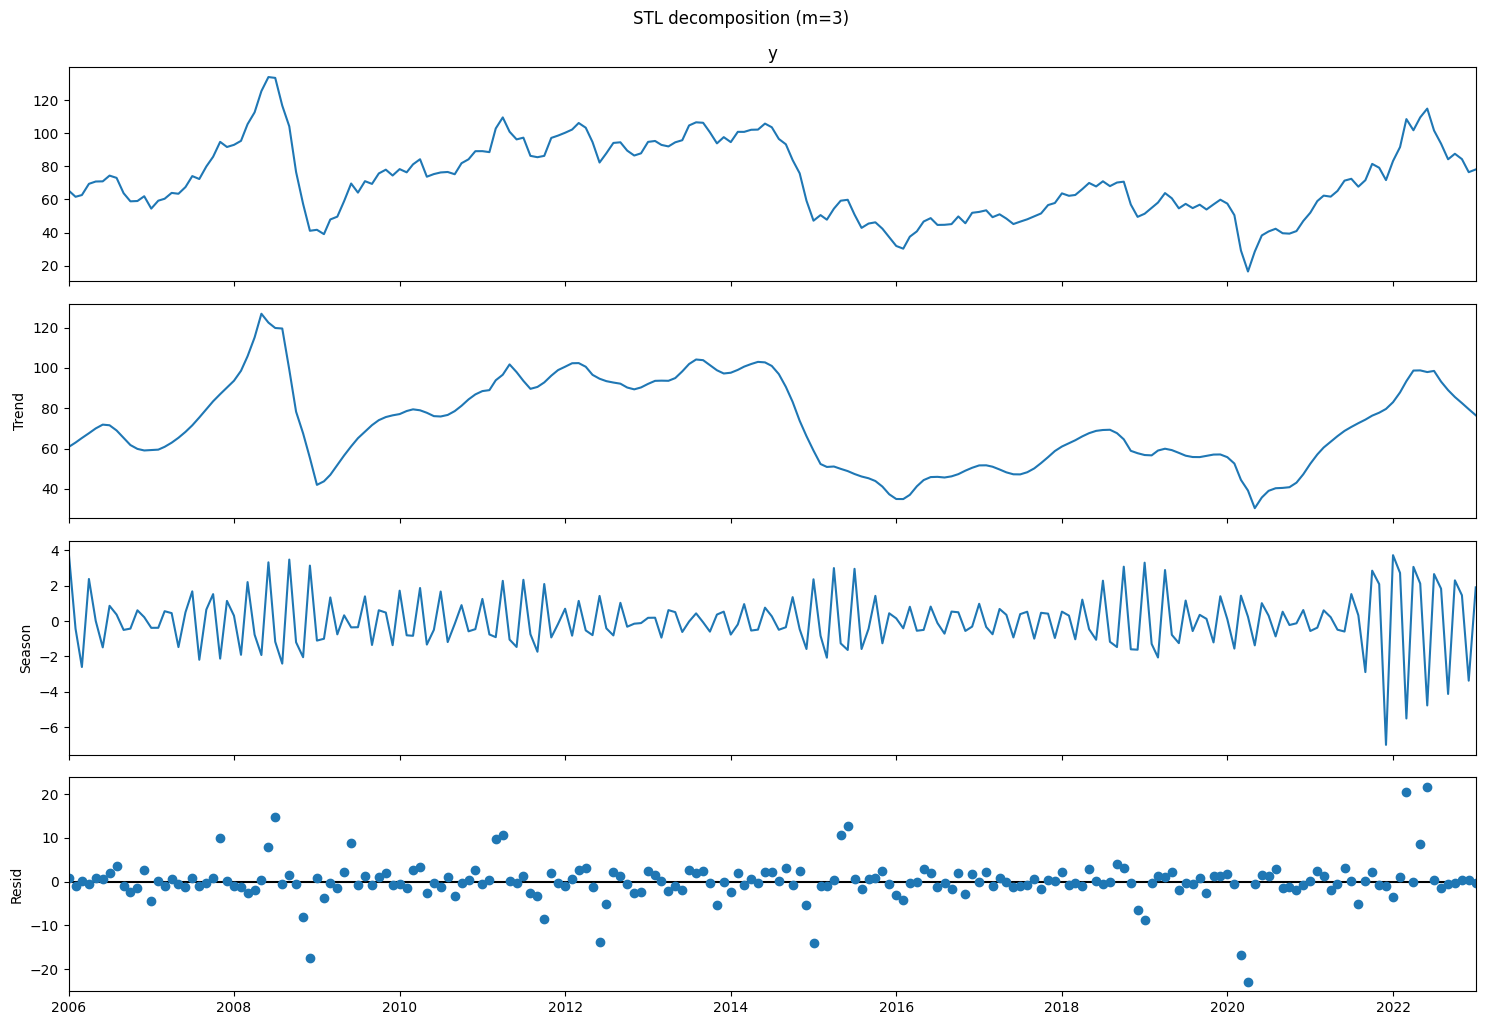

<Figure size 1500x1000 with 0 Axes>


Evaluating SARIMA models:
------------------------------------------------------------
Model                                           AIC   Status
------------------------------------------------------------
SARIMA(0, 0, 0)x(0, 0, 0, 3)                2345.88        ✓
SARIMA(0, 0, 0)x(0, 0, 1, 3)                2072.56        ✓
SARIMA(0, 0, 0)x(0, 0, 2, 3)                1909.75        ✓
SARIMA(0, 0, 0)x(1, 0, 0, 3)                1650.94        ✓
SARIMA(0, 0, 0)x(1, 0, 1, 3)                1642.44        ✓
SARIMA(0, 0, 0)x(1, 0, 2, 3)                1612.70        ✓
SARIMA(0, 0, 0)x(2, 0, 0, 3)                1628.45        ✓
SARIMA(0, 0, 0)x(2, 0, 1, 3)                1626.17        ✓
SARIMA(0, 0, 0)x(2, 0, 2, 3)                1604.39        ✓
SARIMA(0, 0, 1)x(0, 0, 0, 3)                2072.98        ✓
SARIMA(0, 0, 1)x(0, 0, 1, 3)                1875.42        ✓
SARIMA(0, 0, 1)x(0, 0, 2, 3)                1728.53        ✓
SARIMA(0, 0, 1)x(1, 0, 0, 3)                1514.79       

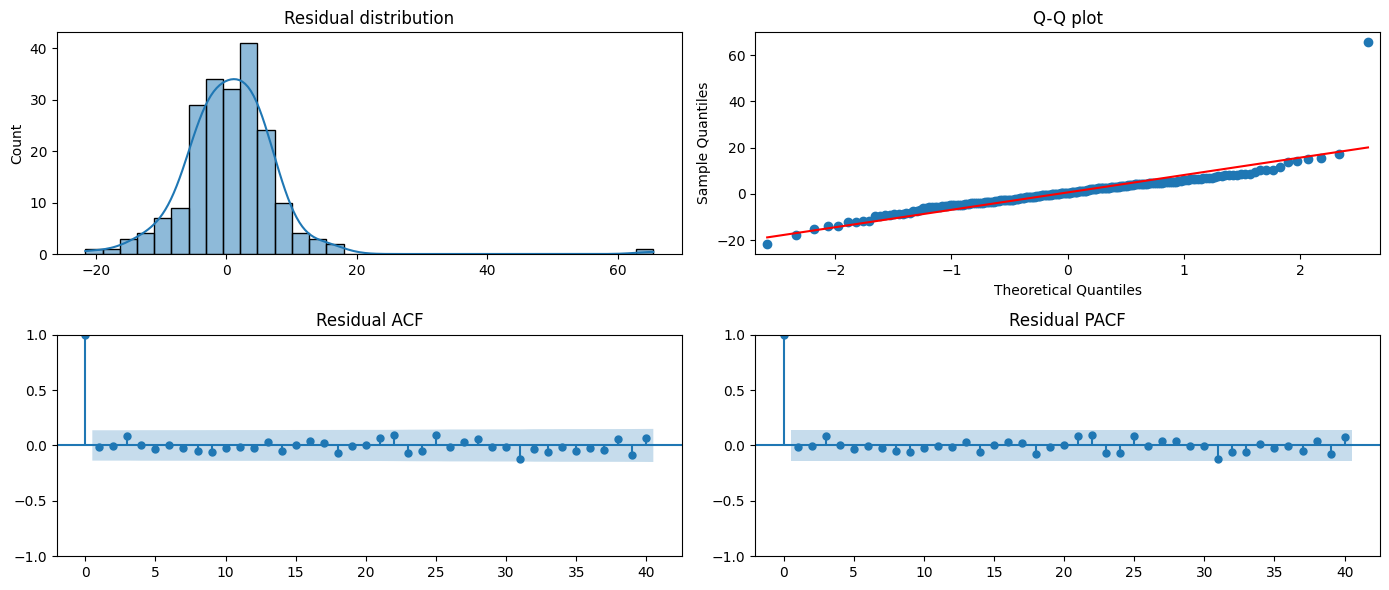

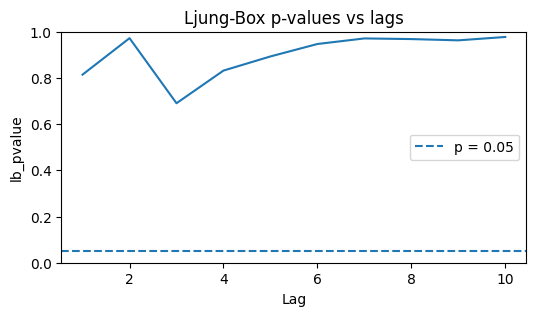

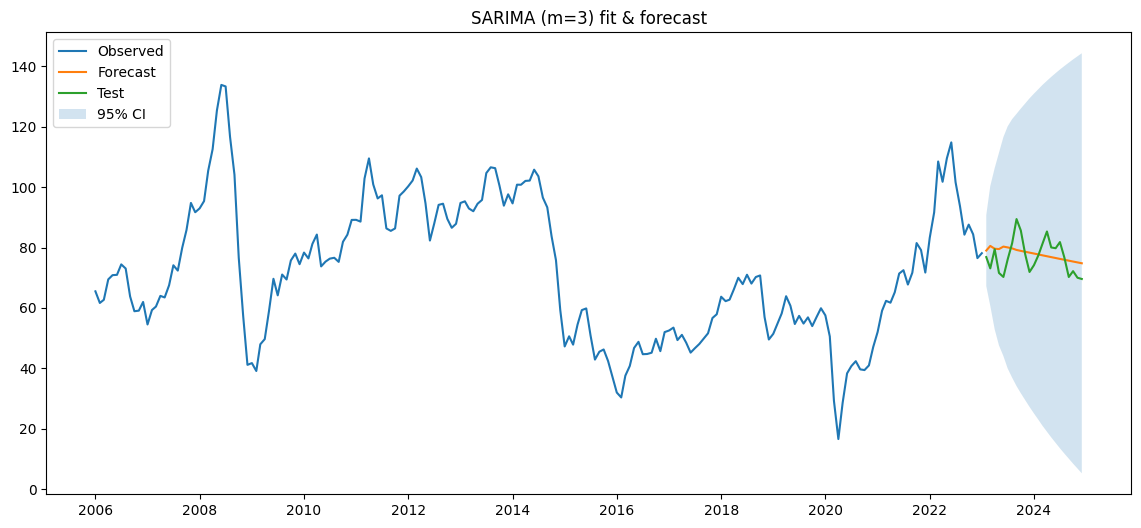

: 

In [ ]:
train_df, test_df = split_train_test(wti_oil_df, test_size=0.1)
sarima_forecast_df = sarima_forecast(
    train_df=train_df,
    test_df=test_df,
    show_plots=True,
)

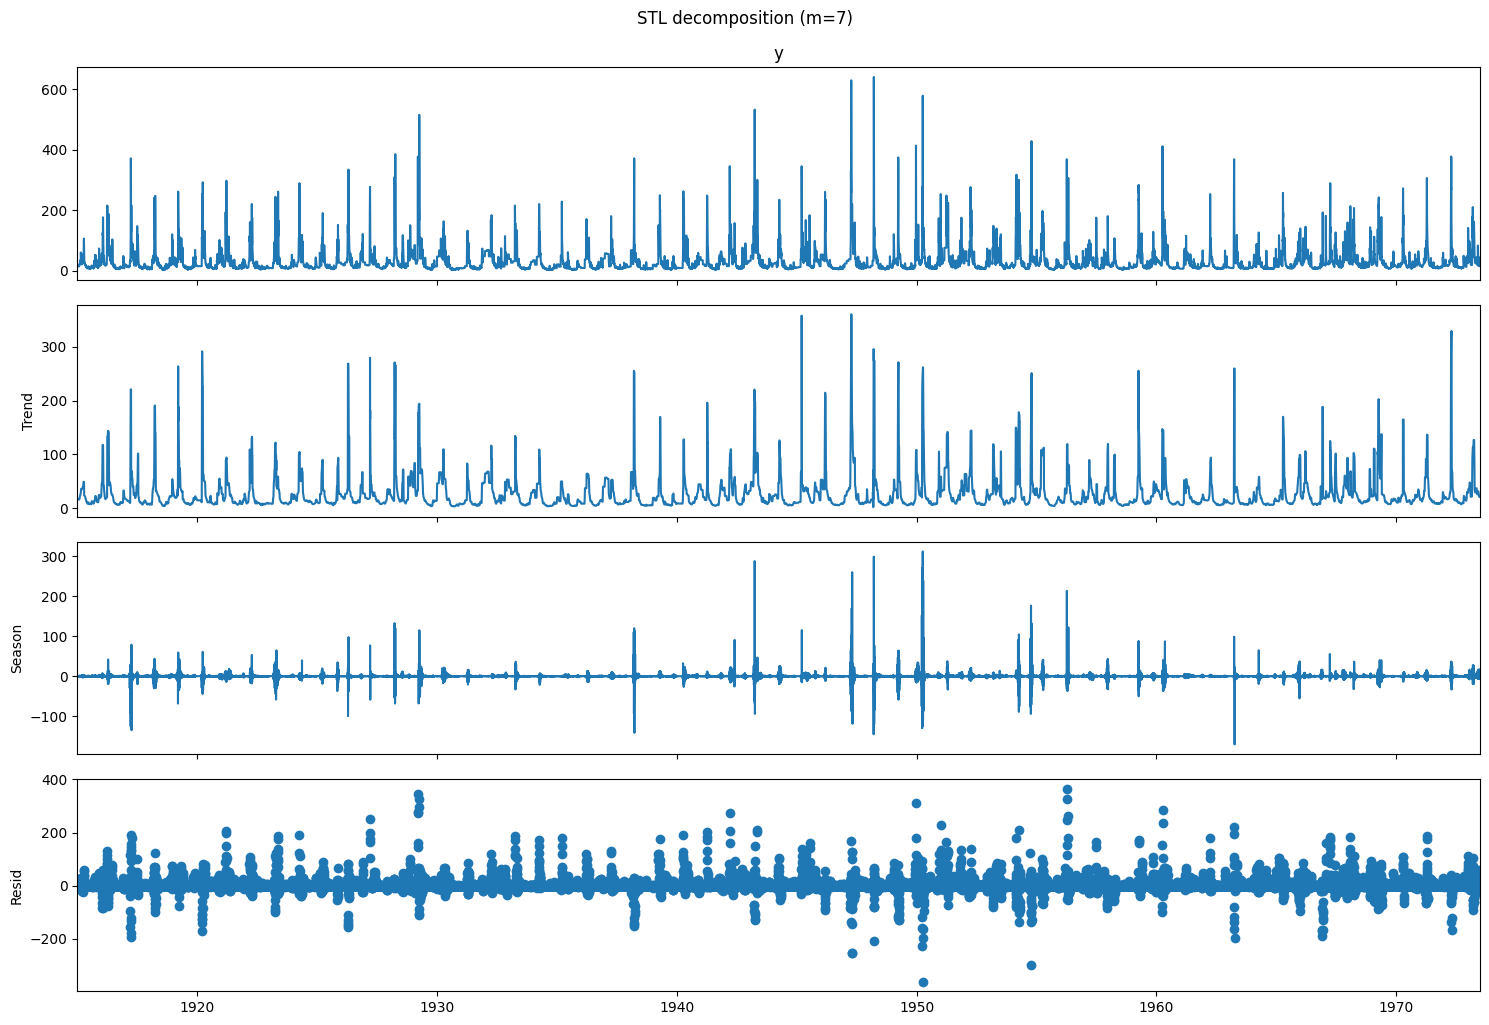

<Figure size 1500x1000 with 0 Axes>


Evaluating SARIMA models:
------------------------------------------------------------
Model                                           AIC   Status
------------------------------------------------------------
SARIMA(0, 0, 0)x(0, 0, 0, 7)              226737.48        ✓
SARIMA(0, 0, 0)x(0, 0, 1, 7)              217608.66        ✓
SARIMA(0, 0, 0)x(0, 0, 2, 7)              214505.07        ✓
SARIMA(0, 0, 0)x(1, 0, 0, 7)              211163.72        ✓
SARIMA(0, 0, 0)x(1, 0, 1, 7)              209964.89        ✓
SARIMA(0, 0, 0)x(1, 0, 2, 7)              209627.27        ✓
SARIMA(0, 0, 0)x(2, 0, 0, 7)              210271.46        ✓
SARIMA(0, 0, 0)x(2, 0, 1, 7)              209000.19        ✓
SARIMA(0, 0, 0)x(2, 0, 2, 7)              208691.58        ✓
SARIMA(0, 0, 1)x(0, 0, 0, 7)              201713.37        ✓
SARIMA(0, 0, 1)x(0, 0, 1, 7)              195555.57        ✓
SARIMA(0, 0, 1)x(0, 0, 2, 7)              192704.92        ✓
SARIMA(0, 0, 1)x(1, 0, 0, 7)              190570.09       

In [ ]:
train_df, test_df = split_train_test(saugeen_river_df, test_size=0.1)
sarima_forecast_df = sarima_forecast(
    train_df=train_df,
    test_df=test_df,
    show_plots=True,
    order_grid=(range(3), range(3)),
    seasonal_order_grid=(range(2), range(2))
)

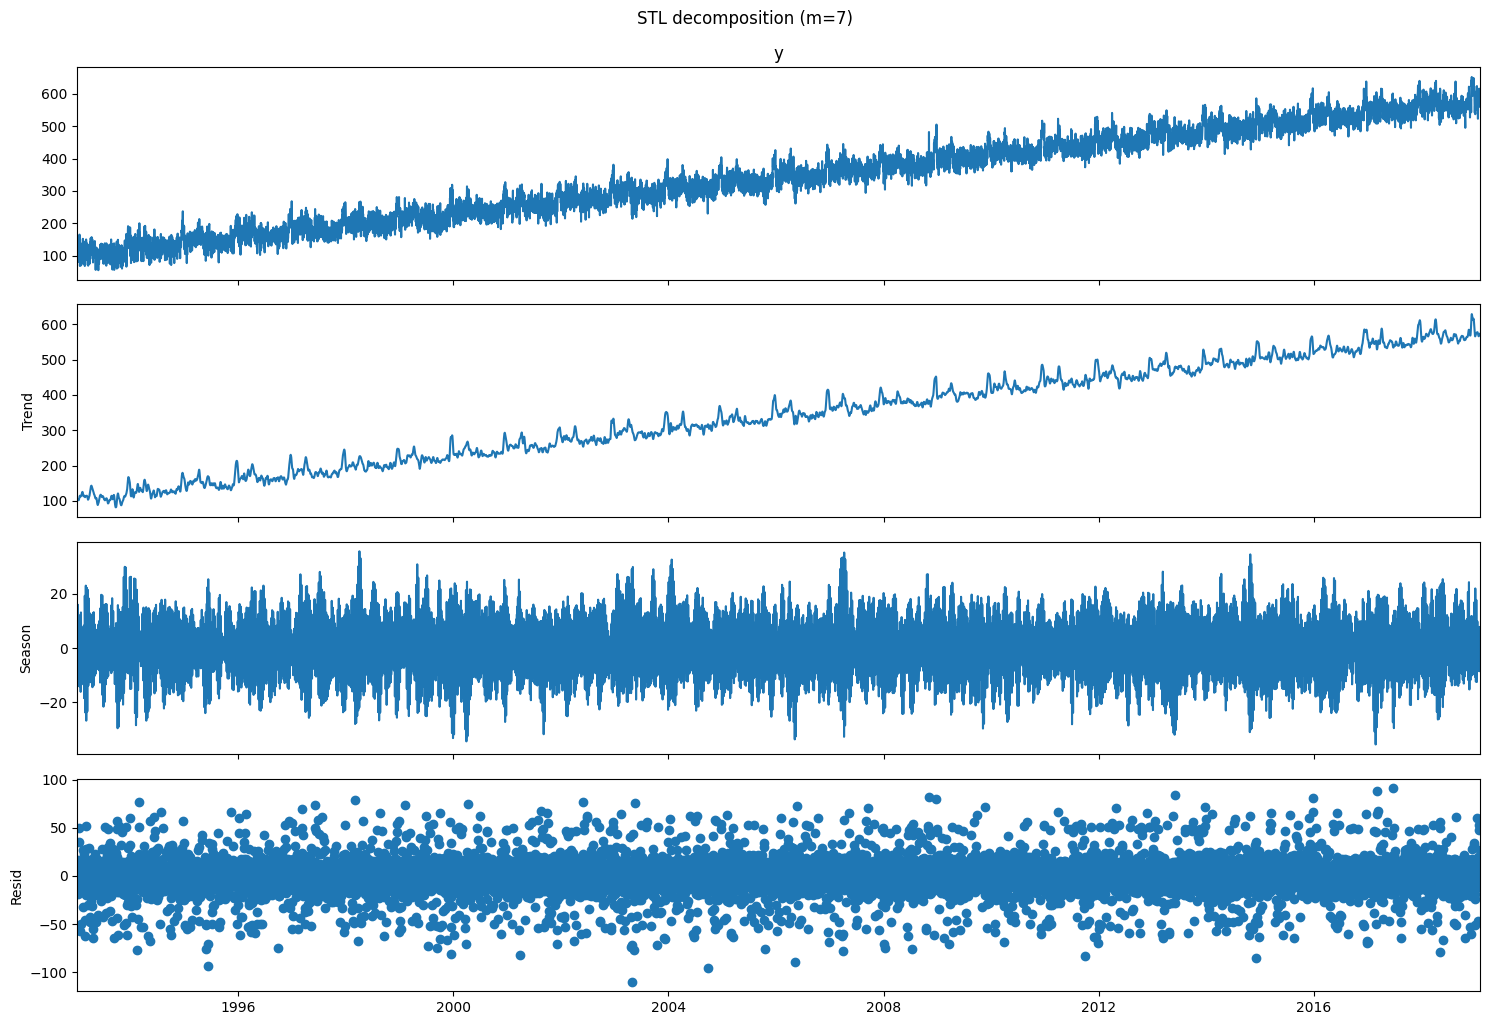

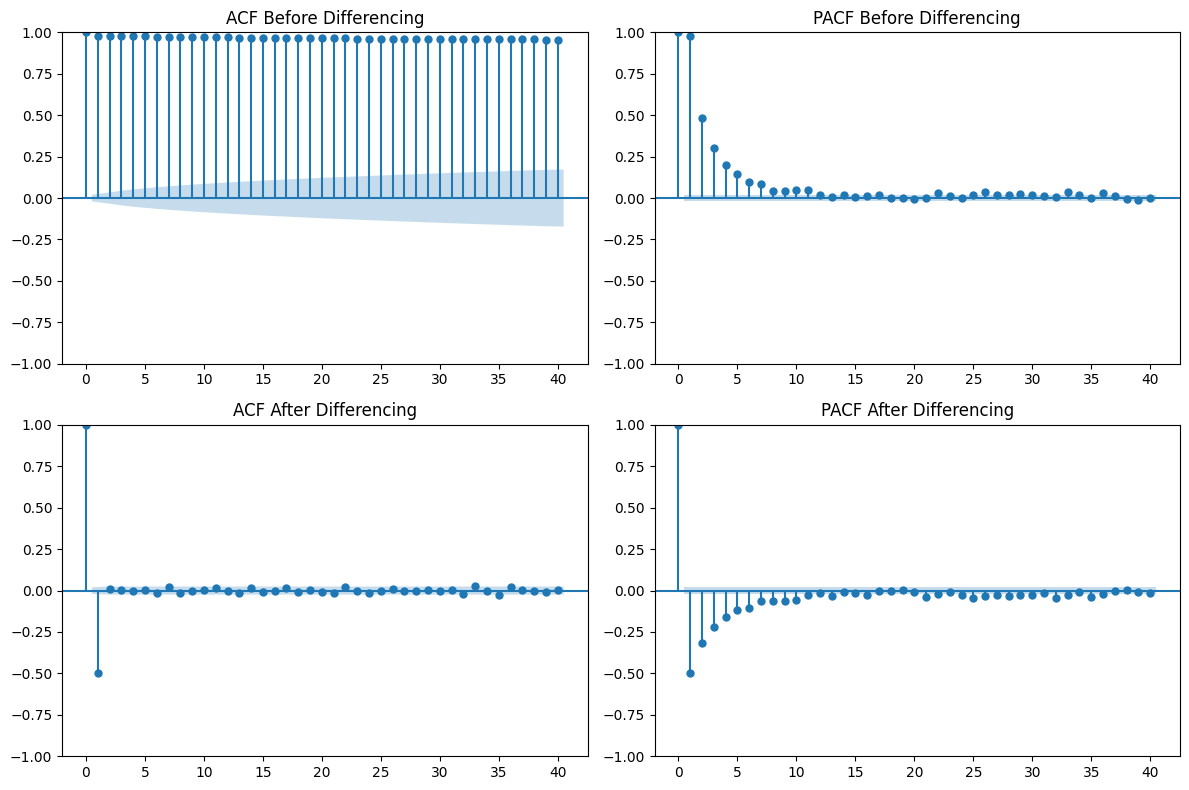


Evaluating SARIMA models:
------------------------------------------------------------
Model                                           AIC   Status
------------------------------------------------------------
SARIMA(0, 1, 0)x(0, 0, 0, 7)               91095.95        ✓
SARIMA(0, 1, 0)x(0, 0, 1, 7)               91033.61        ✓
SARIMA(0, 1, 0)x(1, 0, 0, 7)               91042.58        ✓
SARIMA(0, 1, 0)x(1, 0, 1, 7)               91032.14        ✓
SARIMA(0, 1, 1)x(0, 0, 0, 7)               86294.39        ✓
SARIMA(0, 1, 1)x(0, 0, 1, 7)               86239.00        ✓
SARIMA(0, 1, 1)x(1, 0, 0, 7)               86255.21        ✓
SARIMA(0, 1, 1)x(1, 0, 1, 7)               86240.96        ✓
SARIMA(0, 1, 2)x(0, 0, 0, 7)               86287.90        ✓
SARIMA(0, 1, 2)x(0, 0, 1, 7)               86227.40        ✓
SARIMA(0, 1, 2)x(1, 0, 0, 7)               86257.14        ✓
SARIMA(0, 1, 2)x(1, 0, 1, 7)               86228.02        ✓
SARIMA(1, 1, 0)x(0, 0, 0, 7)               88393.26       

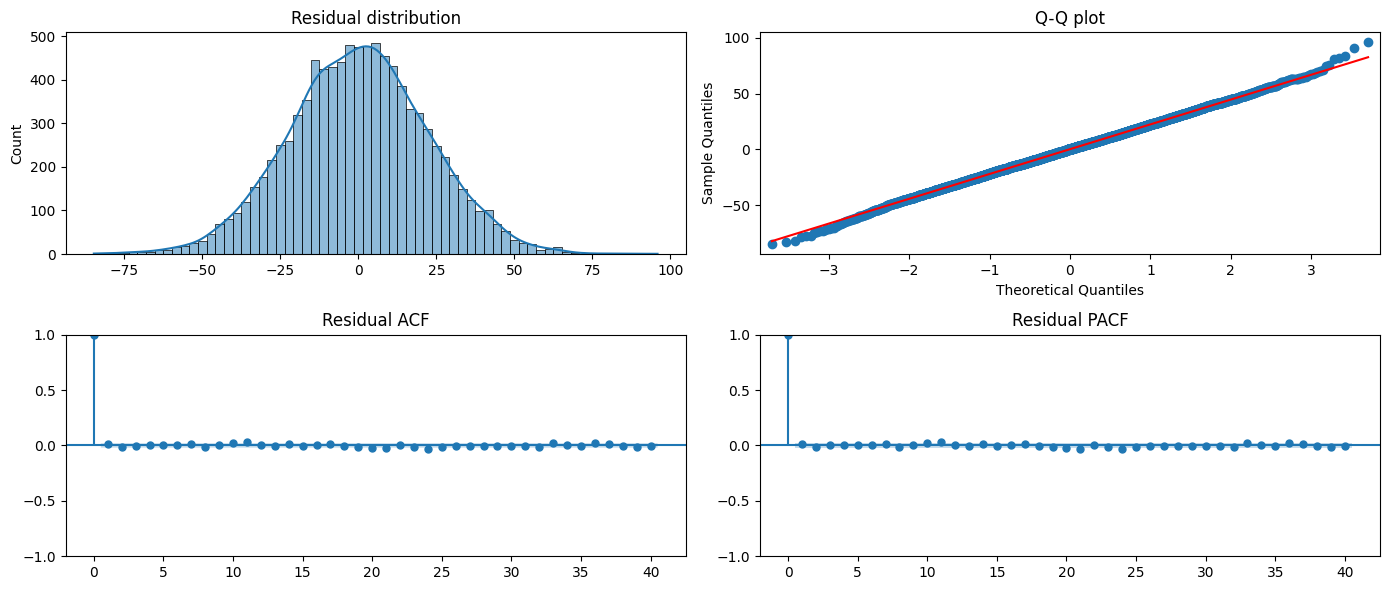

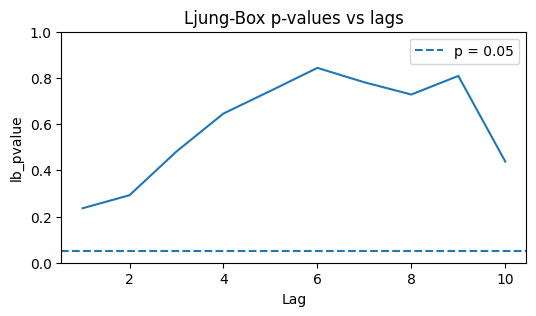

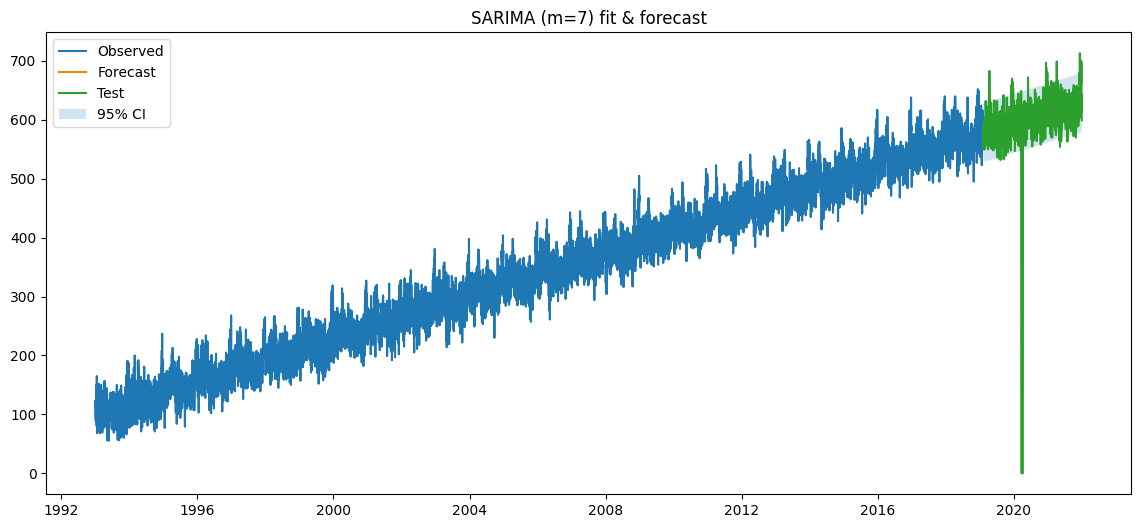

In [ ]:
train_df, test_df = split_train_test(egg_sales_df, test_size=0.1)
sarima_forecast_df = sarima_forecast(
    train_df=train_df,
    test_df=test_df,
    show_plots=True,
)

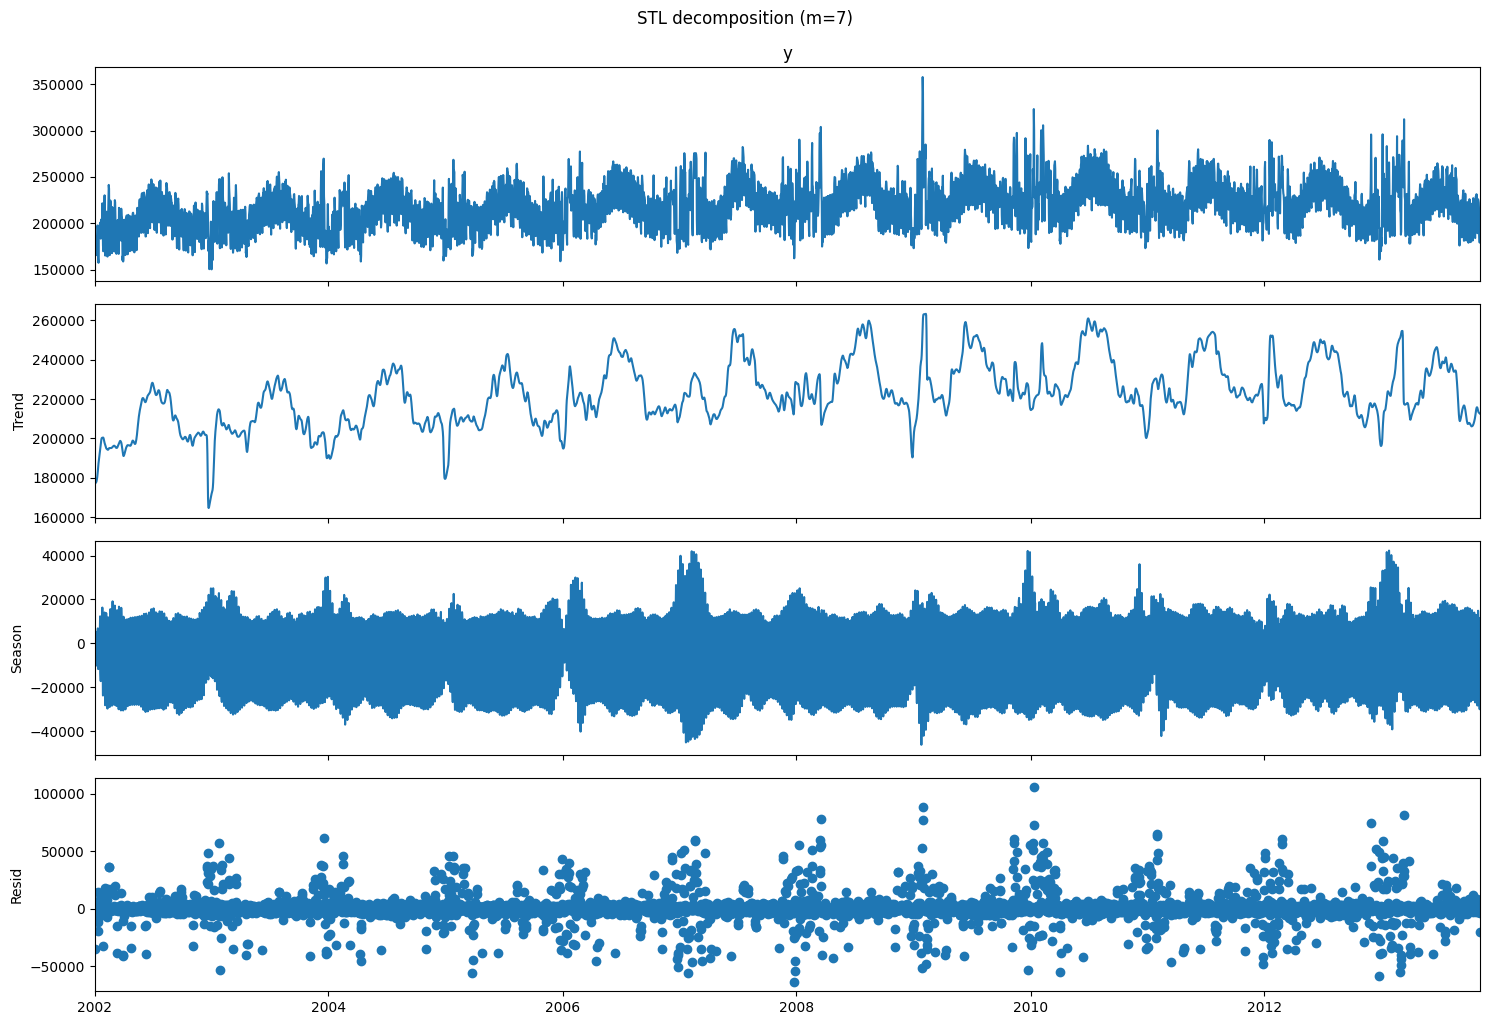

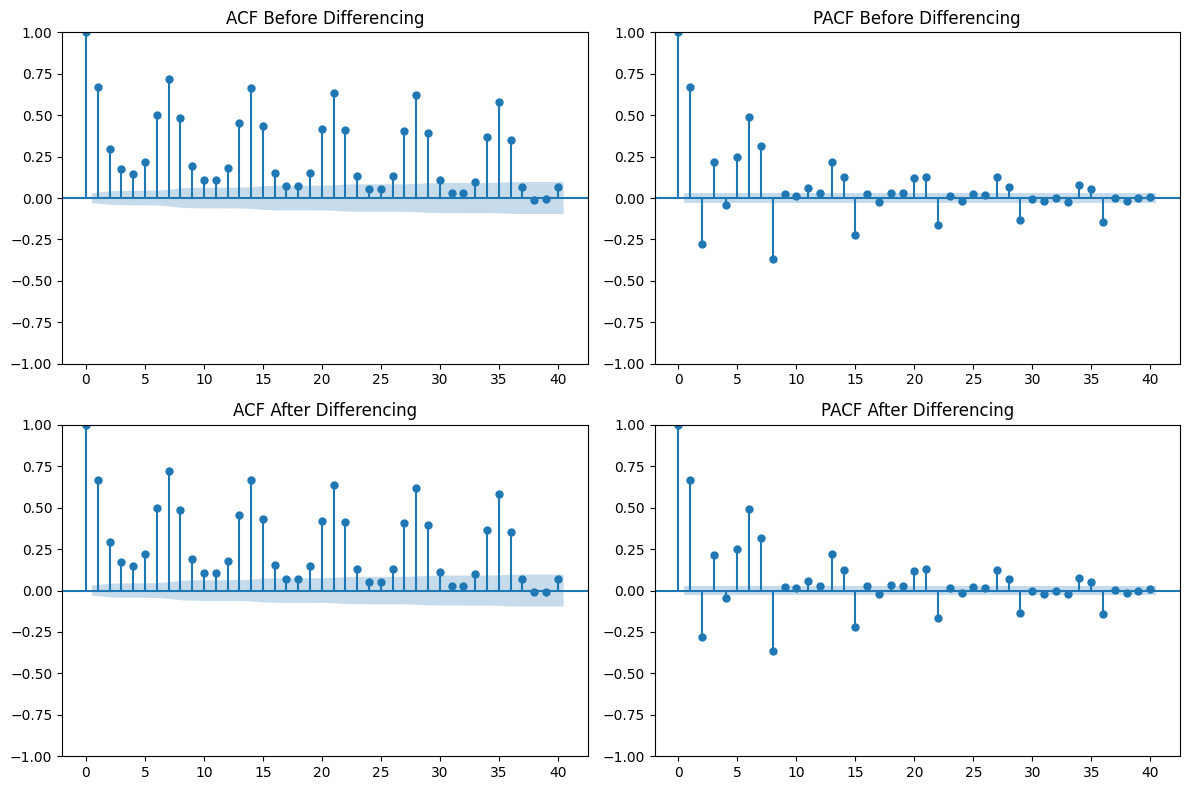


Evaluating SARIMA models:
------------------------------------------------------------
Model                                           AIC   Status
------------------------------------------------------------
SARIMA(0, 0, 0)x(0, 0, 0, 7)              118854.93        ✓
SARIMA(0, 0, 0)x(0, 0, 1, 7)              115603.92        ✓
SARIMA(0, 0, 0)x(1, 0, 0, 7)               97364.18        ✓
SARIMA(0, 0, 0)x(1, 0, 1, 7)               96450.38        ✓
SARIMA(0, 0, 1)x(0, 0, 0, 7)              115623.37        ✓
SARIMA(0, 0, 1)x(0, 0, 1, 7)              114707.61        ✓
SARIMA(0, 0, 1)x(1, 0, 0, 7)              114352.46        ✓
SARIMA(0, 0, 1)x(1, 0, 1, 7)              114296.54        ✓
SARIMA(0, 0, 2)x(0, 0, 0, 7)              114881.86        ✓
SARIMA(0, 0, 2)x(0, 0, 1, 7)              114430.95        ✓
SARIMA(0, 0, 2)x(1, 0, 0, 7)              114358.58        ✓
SARIMA(0, 0, 2)x(1, 0, 1, 7)              114275.89        ✓
SARIMA(1, 0, 0)x(0, 0, 0, 7)               98245.00       

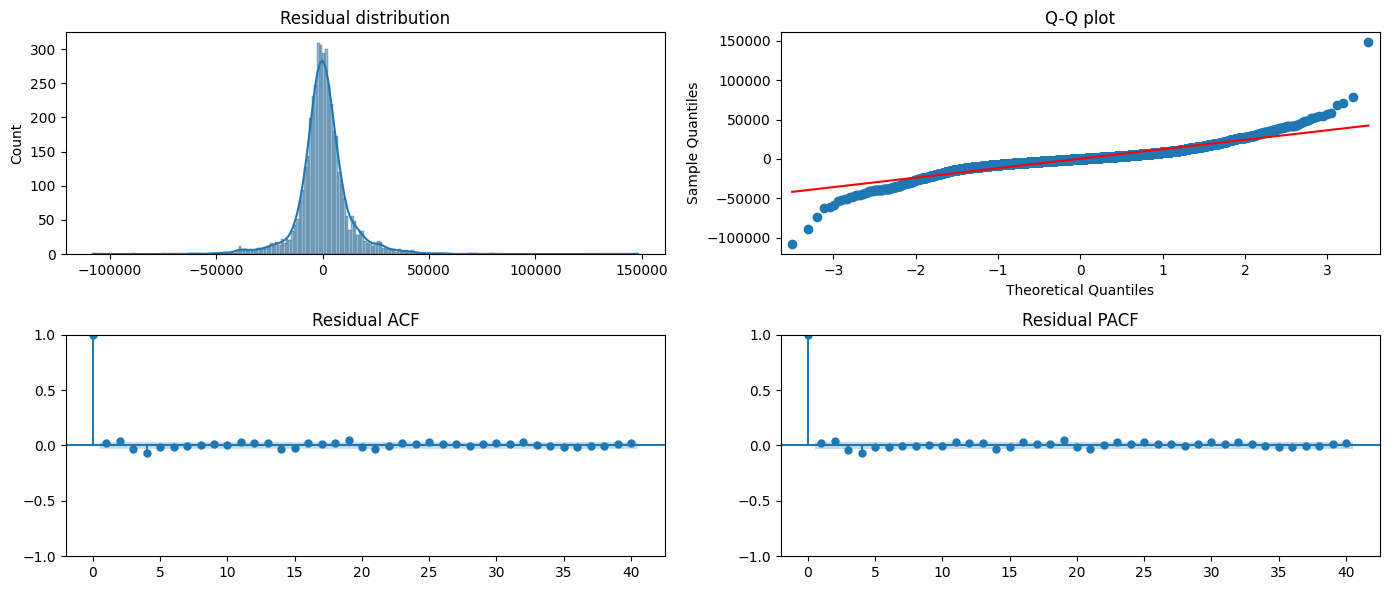

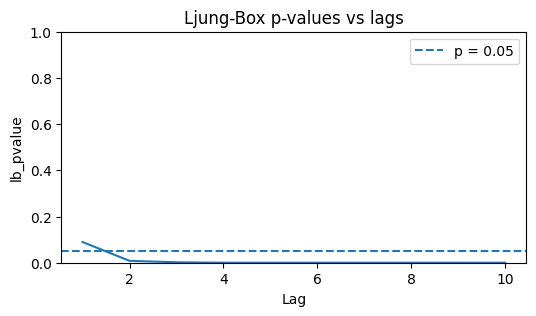

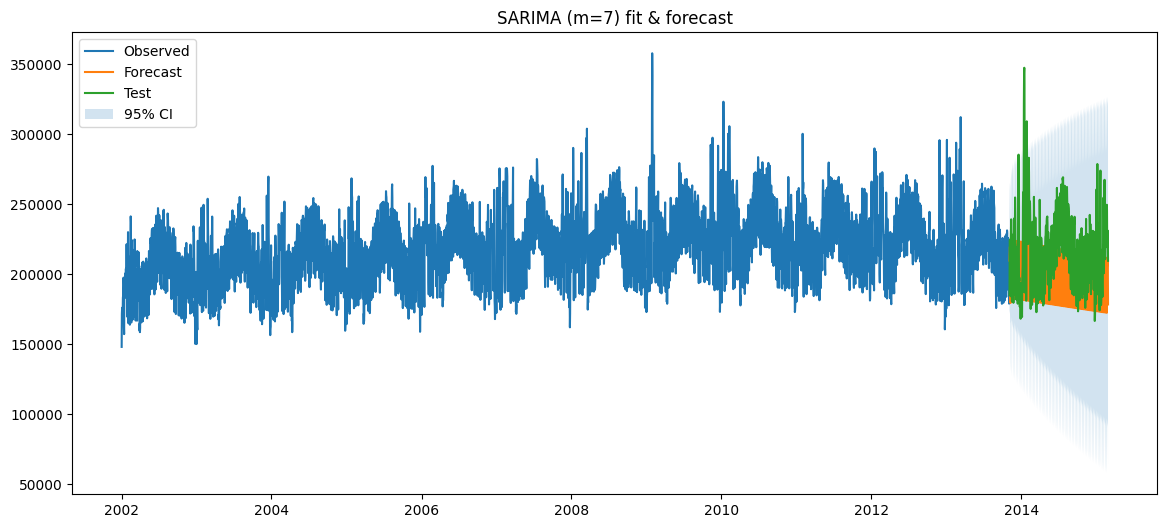

In [ ]:
train_df, test_df = split_train_test(australian_electricity_demand_df, test_size=0.1)
sarima_forecast_df = sarima_forecast(
    train_df=train_df,
    test_df=test_df,
    show_plots=True,
)

Auto-inferred method name: 'sarima_forecast'


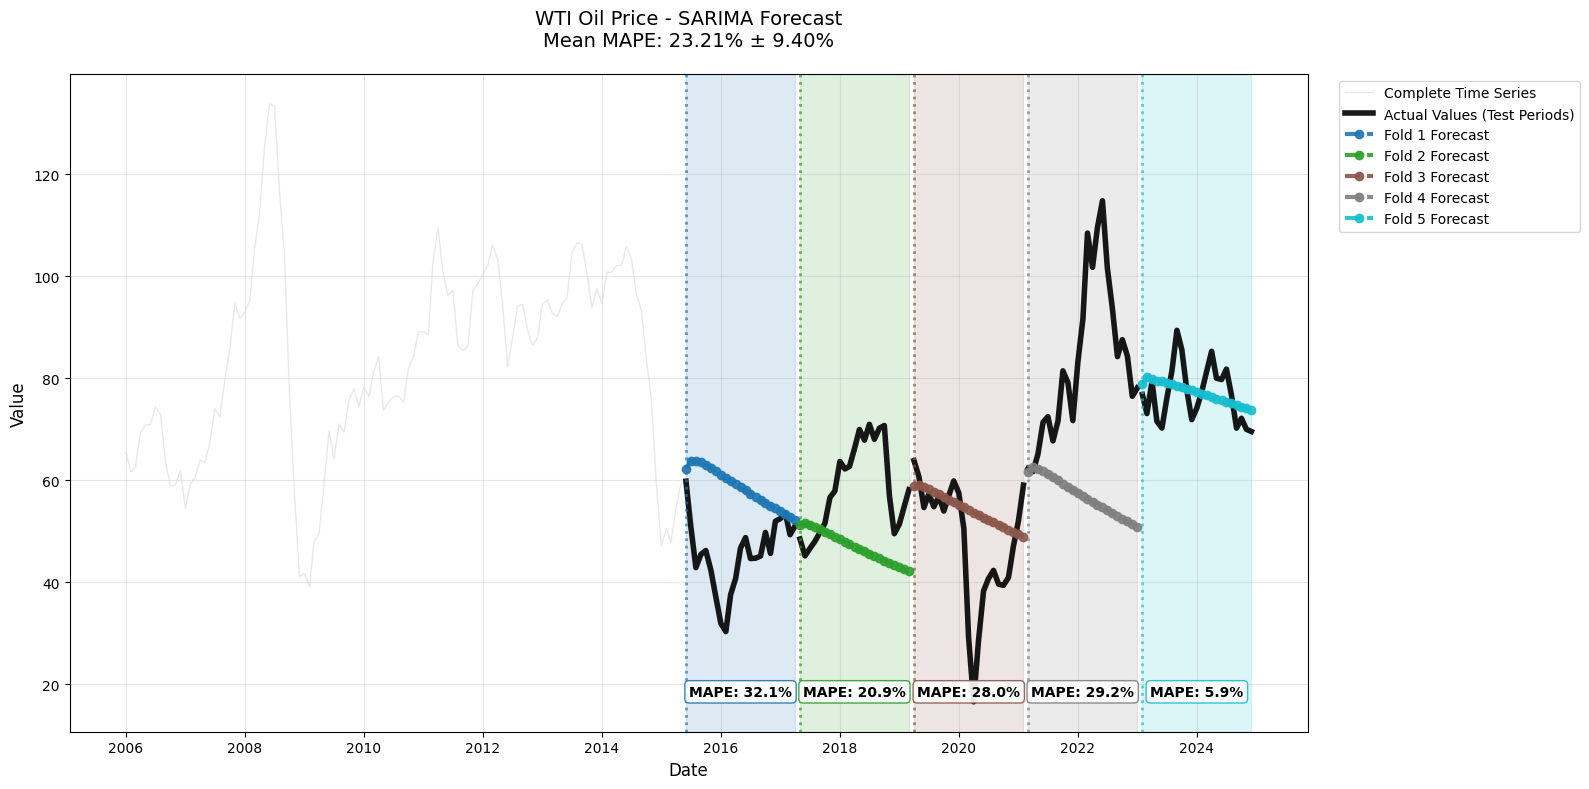


Results saved to cv_results.json under method 'sarima_forecast' for dataset 'wti_oil'
Auto-inferred method name: 'sarima_forecast'


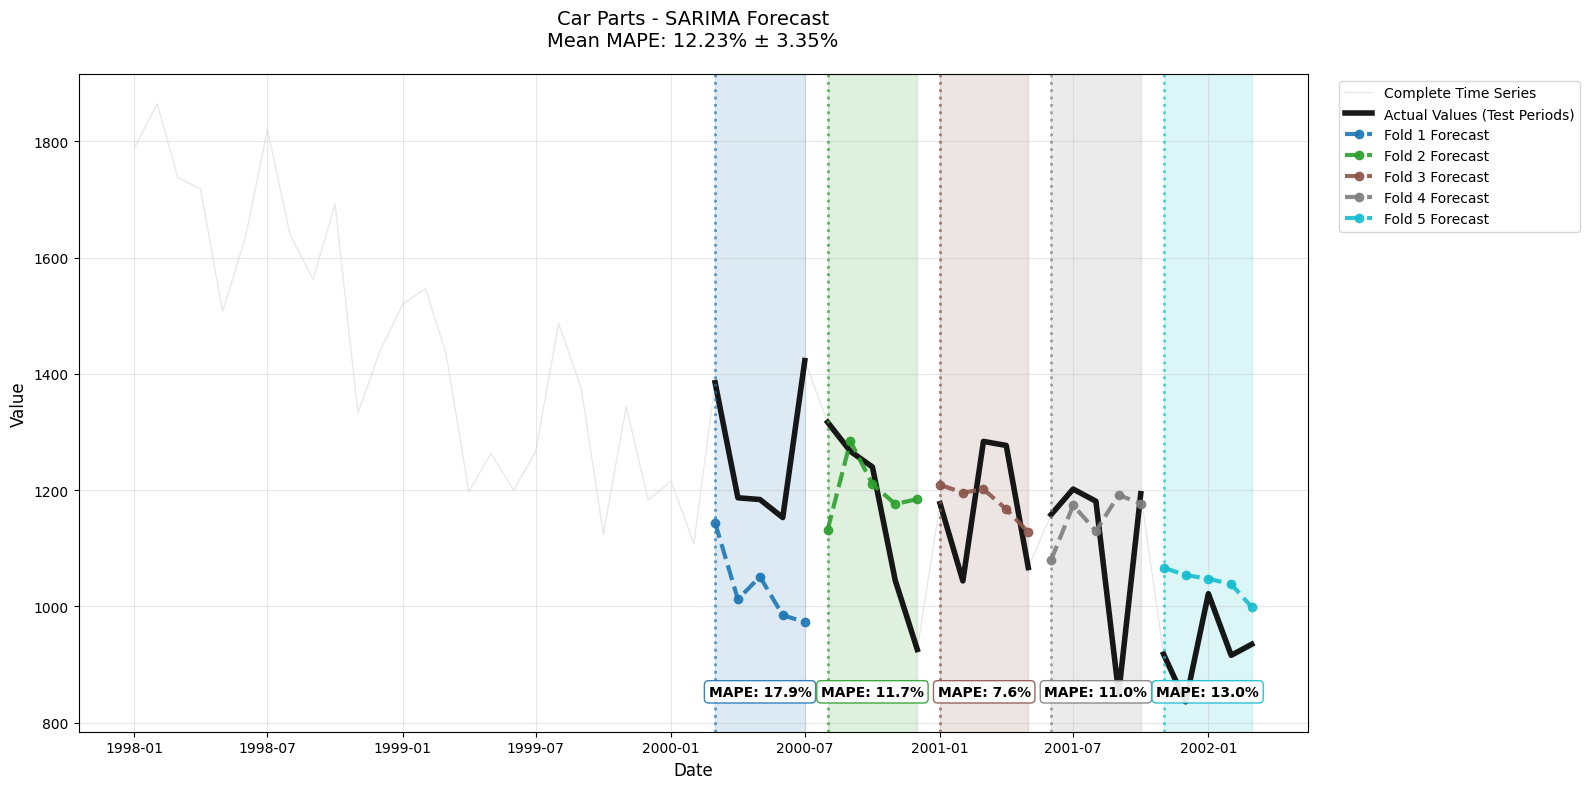


Results saved to cv_results.json under method 'sarima_forecast' for dataset 'car_parts'
Auto-inferred method name: 'sarima_forecast'


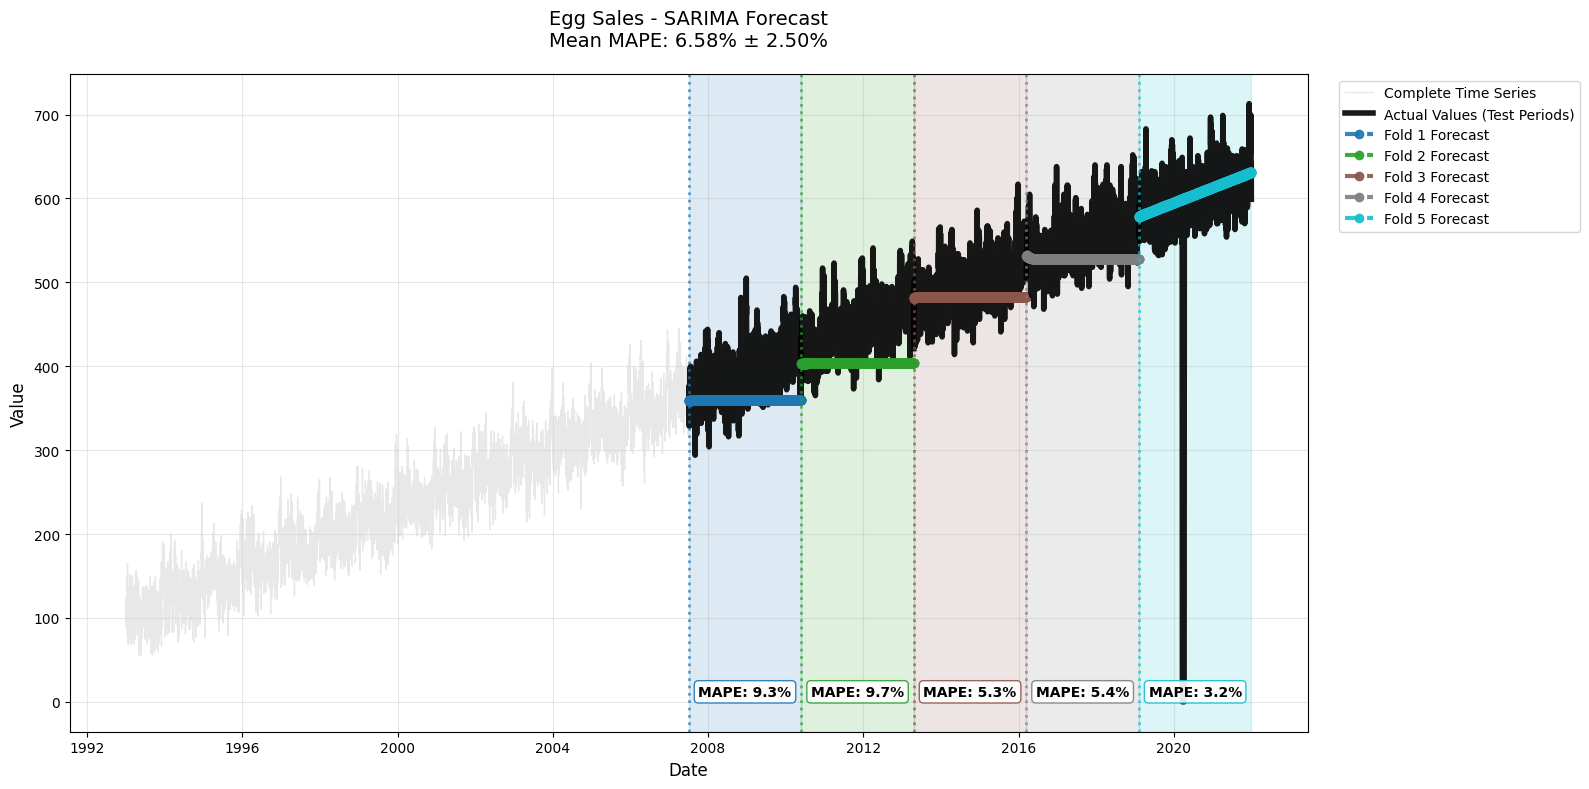


Results saved to cv_results.json under method 'sarima_forecast' for dataset 'egg_sales'
Auto-inferred method name: 'sarima_forecast'


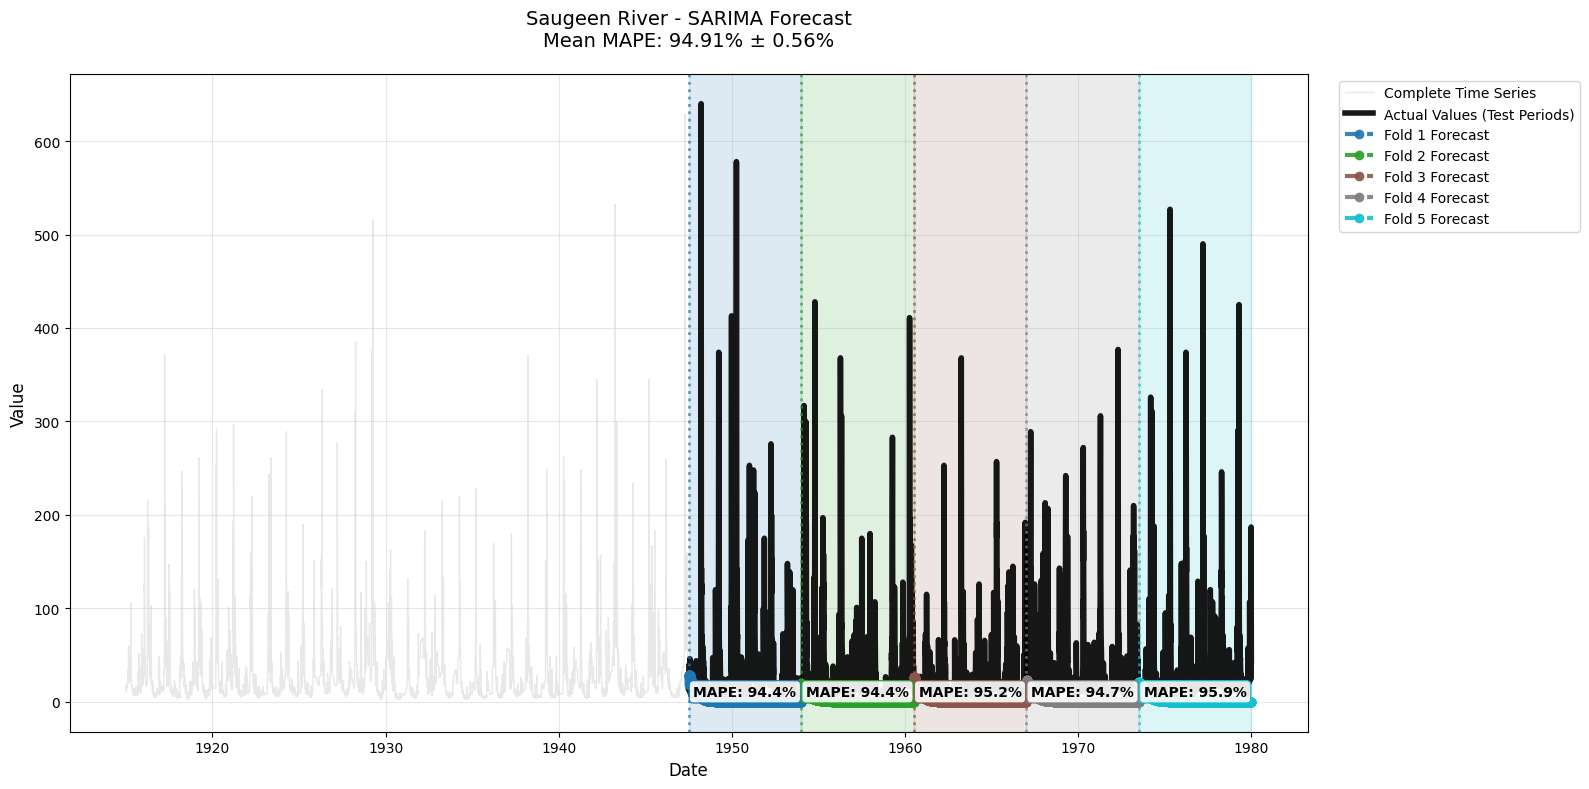


Results saved to cv_results.json under method 'sarima_forecast' for dataset 'saugeen_river'
Auto-inferred method name: 'sarima_forecast'


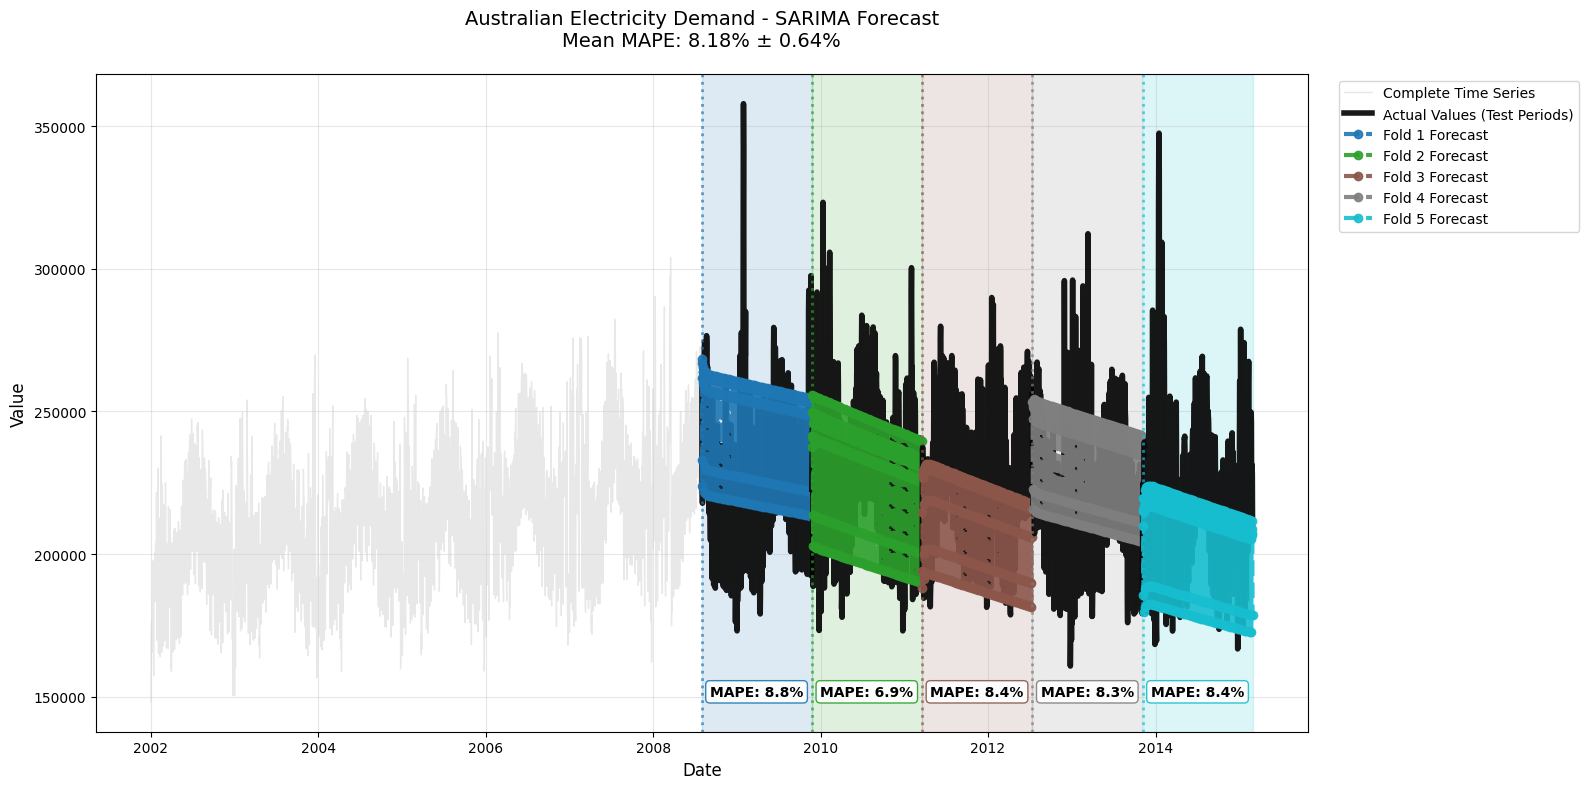


Results saved to cv_results.json under method 'sarima_forecast' for dataset 'australian_electricity_demand'


In [ ]:
plot_comprehensive_cv_results(wti_oil_df, sarima_forecast, n_splits=5, dataset_name='wti_oil',
                              title="WTI Oil Price - SARIMA Forecast")

plot_comprehensive_cv_results(car_parts_df, sarima_forecast, n_splits=5, dataset_name='car_parts',
                              title="Car Parts - SARIMA Forecast")

plot_comprehensive_cv_results(egg_sales_df, sarima_forecast, n_splits=5, dataset_name='egg_sales',
                              title="Egg Sales - SARIMA Forecast")
plot_comprehensive_cv_results(saugeen_river_df, sarima_forecast, n_splits=5, dataset_name='saugeen_river',
                              title="Saugeen River - SARIMA Forecast")
plot_comprehensive_cv_results(australian_electricity_demand_df, sarima_forecast, n_splits=5, dataset_name='australian_electricity_demand',
                              title="Australian Electricity Demand - SARIMA Forecast")
